In [4]:
# Import Libraries

# We can ignore the numpy size difference warnings that come up because of
#  differences in numpy and matplotlib versions
#import warnings
#warnings.filterwarnings("ignore", message="numpy.dtype size changed")
#warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#from ConfigParser import SafeConfigParser
from PIL import Image, ExifTags

#import pynemo
import multiprocessing
import scipy.ndimage
import numpy as np
%matplotlib inline
from pylab import *
import caffe
#import h5py
import time
import cv2
import os
import csv
import scipy 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import pynemo

#sys.path.append('utils')
from utils.TrainNet import train, trainXSteps
from utils.Vis import vis_make_palette, vis_color_seg, checkEXIFRotation

# caffe.set_mode_cpu()
# print("CPU mode")

caffe.set_mode_gpu()
caffe.set_device(0)
# caffe.set_mode_cpu()

print("GPU mode")

print('OK')

GPU mode
OK


In [4]:
# fixed square size to all images
# Didn't understand this block!!!!!!!!!

CONST_IMG_SIZE = 512
CONST_IMG_DIMS = 3 # set to 3 for non-masktrack / normal training

TRAIN_TOTALSTEPS = 800
TRAIN_SOLVER_STEPS = 10
TRAIN_EPOCHS_TO_AVG_OVER = 100  #iterations averaged over are this * solver_steps
TRAIN_INITIAL_STEPS = 100

In [5]:
# This part of the code resizes the images

def get_proper(img_data, desired_size = 512):
#     Display the original image
    """
    fig12,ax12 = plt.subplots(1)
    ax12.imshow(img_data)
    plt.title("Before manipulation")
    plt.show()
    """    
    im = img_data
    old_size = im.size  # old_size[0] is in (width, height) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    
    # create a new image and paste the resized on it
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
#     Display the Resized image
    """
    new_im.show()
    fig13,ax13 = plt.subplots(1)
    ax13.imshow(new_im)
    plt.title("After manipulation")
    plt.show()
    """
    return new_im
    

In [6]:
def forward_feed(myImagePath):

    im_orig = Image.open(myImagePath)
    fig2,ax2 = plt.subplots(1)
    mySize = im_orig.size
    im = get_proper(im_orig)
    ax2.imshow(im)
    plt.title("Before manipulation")
    plt.show()
        
    im_arr = np.asarray(im)
    #     print(im_arr)
    #     print(type(im_arr), np.shape(im_arr))
    img_list = []
    #     print("The size of data is ", np.shape(img_list))
    #     Doing mean
    im_arr = im_arr +  int(np.median(im_arr))
    print("The calculated mean of the image is ")
    print(int(np.mean(im_arr)))
    im_arr[im_arr > 255] = 255
    im_arr[im_arr < 0] = 0 
    #     print(im_arr)
    """
    fig3,ax3 = plt.subplots(1)
    plt.title("After manipulation")
    ax3.imshow(im_arr)
    """

    print('*' * 100)
    im3 = cv2.cvtColor(im_arr, cv2.COLOR_BGR2RGB)
    fig4,ax4 = plt.subplots(1)
    plt.title("After CV2 manipulation")
    ax4.imshow(im3)
    print('The shape of im3 is ', np.shape(im3))

#     Code to flip the image; can be the second one as well but seems very unlikely!
#     im3 = np.fliplr(im3)
#     im3 = np.flipud(im3)
#     im4 = im3.transpose((1,2,0))
    im4 = im3.transpose((2,1,0))
    img_list.append(im4)


    """
    Unfortunatly it is impossible to display the image once the transformation occurs
    but lets do a sanity check; the image should be flipped up-side down and left-right
    #     im4 = np.fliplr(im3)
    im5 = im4.transpose((1,2,0))
    im5 = im5.transpose((1,2,0))

    fig5,ax5 = plt.subplots(1)
    plt.title("Scanity check")
    ax5.imshow(im5)

    print('The shape of im4 is ', np.shape(im4))
    img_list.append(im4)
    print('The shape of img_list is ', np.shape(img_list))

    """
#     load the net here
    net = caffe.Net('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/FullDenseNet-Forward.prototxt',
                '/opt/caffe/neurala/training-pipeline/models/weights/snapshot_iter_40000.caffemodel'
               , caffe.TEST)
    
#     net = caffe.Net('/opt/caffe/neurala/training-pipeline/models/SDK_Nets/allNet5.prototxt',
#                 '/opt/caffe/neurala/training-pipeline/models/SDK_Nets/allNet5.caffemodel'
#                , caffe.TEST)
    
#     net = caffe.Net('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/FullDenseNet-Forward.prototxt',
#                 '/opt/caffe/neurala/training-pipeline/models/weights/snapshot_iter_300000.caffemodel'
#                , caffe.TEST)
    
    #     Code to do the forward pass
    net.blobs['data'].reshape(*np.asarray(img_list).shape)
    net.blobs['data'].data[...] = img_list
    print("The shape of image blob is")
    print(*np.asarray(img_list).shape)
    net.forward()
    rpn_bbox_pred = net.blobs['rpn/outputBoxes'].data
    print("The shape of rpn_bbox_pred is ")
    print(np.shape(rpn_bbox_pred))
#     rpn_bbox_targets = net.blobs['rpn_bbox_targets'].data
    rpn_cls_score = net.blobs['softmax'].data
    return rpn_bbox_pred, rpn_cls_score


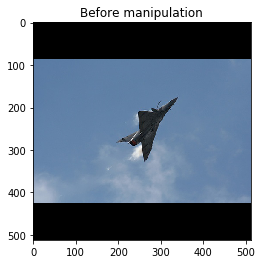

The calculated mean of the image is 
131
****************************************************************************************************
The shape of im3 is  (512, 512, 3)
The shape of image blob is
1 3 512 512
The shape of rpn_bbox_pred is 
(1, 84, 32, 32)
The shape of rpn_bbox_pred is 
(1, 84, 32, 32)
The shape of rpn_cls_score is 
(1, 22, 32, 32)


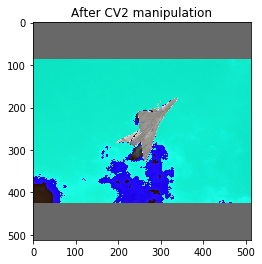

In [7]:
# myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/people_flower_ocean_sky_1.jpg"
# myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/cat.jpg"
# myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/cats.jpg"
# myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/women.jpg"
# myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/trump.jpg"
# myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/duck.jpg"
# myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/plat.jpg"
# myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/car.jpg"
# myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/sheep.jpg"
myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/airplane.jpg"


# rpn_bbox_pred, rpn_bbox_targets, rpn_cls_score = forward_feed(myImagePath)
rpn_bbox_pred, rpn_cls_score = forward_feed(myImagePath)

print("The shape of rpn_bbox_pred is ")
print(np.shape(rpn_bbox_pred))
# print("The shape of rpn_bbox_targets is ")
# print(np.shape(rpn_bbox_targets))
print("The shape of rpn_cls_score is ")
print(np.shape(rpn_cls_score))


In [1]:
# myIndex is the particular 1-21 index; x & y are the location in the 32x32 grid; tmp_rpn_bbox_mod use to get the x y 
# movements, and width and height adjustments
def index22_to_proposalbox(myIndex,x,y, tmp_rpn_bbox_mod):
    
    # if 0 it predicts no box
    if myIndex <= 0:
        return None
    
    mytmp_index = (myIndex-1) * 4
    
    
    ANCHOR_SCALES = [1, 3, 7, 11, 17, 23, 29]
    ANCHOR_RATIOS = [0.5, 1, 2]
    ANCHOR_RATIOS_Y = [math.sqrt(0.5), 1, math.sqrt(2)]
    ANCHOR_RATIOS_X = [math.sqrt(2), 1, math.sqrt(0.5)]
    
    # return to 0-20 (was 0-20 and anchors were 1-21)
    myIndex -= 1
    
    scale = myIndex%7
    box = math.floor(myIndex/7)
    
    ## We want the reverse of this
    # where we inputted:
    # gt_ctr_x
    # gt_ctr_y
    # gt_widths
    # gt_heights
    #
    # and we got as output
    # targets_dx
    # targets_dy
    # targets_dw
    # targets_dh
    
    # OG Code:
    #     targets_dx = (gt_ctr_x - ex_ctr_x) / (ex_widths + 1e-7)
    #     targets_dy = (gt_ctr_y - ex_ctr_y) / (ex_heights + 1e-7)
    #     targets_dw = np.log(gt_widths / (ex_widths + 1e-7))
    #     targets_dh = np.log(gt_heights / (ex_heights + 1e-7))
    
    # That means the inverse is:
    #     gt_ctr_x = (targets_dx * ex_widths) + ex_ctr_x
    #     gt_ctr_y = (targets_dy * ex_heights) + ex_ctr_y
    #     gt_widths = (10**targets_dw) * ex_widths
    #     gt_heights = (10**targets_dh) * ex_heights    

    targets_dx = tmp_rpn_bbox_mod[0][mytmp_index+0][y][x]
    targets_dy = tmp_rpn_bbox_mod[0][mytmp_index+1][y][x]
    targets_dw = tmp_rpn_bbox_mod[0][mytmp_index+2][y][x]
    targets_dh = tmp_rpn_bbox_mod[0][mytmp_index+3][y][x]
    
    ex_ctr_x = (x * 16) + 8
    ex_ctr_y = (y * 16) + 8
    ex_widths = 16 * ANCHOR_SCALES[scale] * ANCHOR_RATIOS_X[box]
    ex_heights = 16 * ANCHOR_SCALES[scale] * ANCHOR_RATIOS_Y[box]
    
    gt_ctr_x = ((targets_dx * ex_widths) + ex_ctr_x)
    gt_ctr_y = ((targets_dy * ex_heights) + ex_ctr_y)
    gt_widths = (math.exp(targets_dw)) * (ex_widths)
    gt_heights = (math.exp(targets_dh)) * (ex_heights)
    
    xCenter = gt_ctr_x
    yCenter = gt_ctr_y
    width = gt_widths
    height = gt_heights

    xmin = xCenter - (width / 2)
    ymin = yCenter - (height / 2)
    xmax = xCenter + (width / 2)
    ymax = yCenter + (height / 2)
    
    # 1 - non-object score
    return [xmin, ymin, xmax, ymax, (1-rpn_cls_score[0][0][y][x])]

    # anchor object score
    # return [xmin, ymin, xmax, ymax, (rpn_cls_score[0][myIndex][y][x])]

# xmin ymin xmax ymax
def IOUCalc(boxes, query_boxes):
    """
    determine overlaps between boxes and query_boxes
    :param boxes: n * 5 bounding boxes (4 + 1 for objectness)
    :param query_boxes: k * 5 bounding boxes (4 + 1 for objectness)
    :return: overlaps: n * k overlaps
    """
    n_ = boxes.shape[0]
    k_ = query_boxes.shape[0]
    overlaps = np.zeros((n_, k_), dtype=np.float)
    for k in range(k_):
        query_box_area = (query_boxes[k, 2] - query_boxes[k, 0] + 1) * (query_boxes[k, 3] - query_boxes[k, 1] + 1)
        for n in range(n_):
            iw = min(boxes[n, 2], query_boxes[k, 2]) - max(boxes[n, 0], query_boxes[k, 0]) + 1
            if iw > 0:
                ih = min(boxes[n, 3], query_boxes[k, 3]) - max(boxes[n, 1], query_boxes[k, 1]) + 1
                if ih > 0:
                    box_area = (boxes[n, 2] - boxes[n, 0] + 1) * (boxes[n, 3] - boxes[n, 1] + 1)
                    all_area = float(box_area + query_box_area - iw * ih)
                    overlaps[n, k] = iw * ih / all_area
    return overlaps


def NMScalc(proposedBox, listOfPreviousBoxes, NMSthreshold=.75):
    # check if the proposed box overlaps with any of the list of previous boxes
    # if they do, check the objecteness score
    # if the proposed box has a higher objectness score, remove all of the overlapping boxes,
    #  and add the proposed box
    # If not, don't add the proposed box
    
    # If there are no previous boxes to overlap to, add the proposed box
    if len(listOfPreviousBoxes) == 0:
        return True
    
    # Calculate the IOU overlap between the proposed box and all previous boxes
    overlapArray = IOUCalc(np.array([proposedBox]),np.array(listOfPreviousBoxes))[0]
    # Filter the list out so we have a list of heavily overlapping previous boxes
    list_of_overlapping_previous_box_indices = np.nonzero(overlapArray > NMSthreshold)[0]
    
    # If there are no heavily overlapping boxes, then nbd, add the proposed box
    if len(list_of_overlapping_previous_box_indices) == 0:
        return True
    
    # set ourselves up to compare the objectness score between the proposed box
    #   and the heavily overlapping ones
    list_of_overlapping_previous_boxes = []
    for x in list_of_overlapping_previous_box_indices:
        list_of_overlapping_previous_boxes.append(listOfPreviousBoxes[x])
    list_of_overlapping_previous_boxes_objectnessScore = [box[4] for box in list_of_overlapping_previous_boxes]
    
    # If the proposed box has a higher objectness score than all other boxes it overlaps with,
    #   Then remove those other boxes
    #   Otherwise don't add this box (because the other boxes are better)
    if np.all(proposedBox[4] > list_of_overlapping_previous_boxes_objectnessScore):
        for index in sorted(list_of_overlapping_previous_box_indices, reverse=True):
            del listOfPreviousBoxes[index]
        return True
    
    return False

# model output
rpn_cls_score_softmax = rpn_cls_score[0].argmax(axis=0)
print("The rpn_cls_score_softmax shape is")
print(np.shape(rpn_cls_score_softmax))
myProposedRects = []
# print("The shape of rpn_bbox_pred is")
# print(np.shape(rpn_bbox_pred))
# print("The rpn_bbox_pred values are")
# print(rpn_bbox_pred)
# count = 0
for x in range(32):
    for y in range(32):
        chosenIndex = rpn_cls_score_softmax[y][x]
        tmpBox = index22_to_proposalbox(chosenIndex,x,y,rpn_bbox_pred)
        if tmpBox:
#             print(tmpBox)
            if NMScalc(tmpBox, myProposedRects, 0.9):
#                 print("in If")
#                 print(tmpBox)
#                 print("out If")
                myProposedRects.append(tmpBox)
#                 count +=1
#print("There are",count,"Rectangles in the model output")



# GT anchors without modification
# rpn_labels_reshaped = rpn_labels[0].astype(int).reshape(-1, 32).transpose()
# myGTRects = []
# count = 0
# for x in range(32):
#     for y in range(32):
#         chosenIndex = rpn_labels_reshaped[y][x]
#         tmpBox = index22_to_proposalbox(chosenIndex,y,x,rpn_bbox_targets)
#         if tmpBox:
# #             print(tmpBox)
#             if NMScalc(tmpBox, myGTRects, 0):
#                 myGTRects.append(tmpBox)
#                 count +=1
# #                 print(tmpBox)
# #                 print("appended")
# print("There are",count,"Rectangles in the GT")

NameError: name 'rpn_cls_score' is not defined

In [2]:
im_orig = Image.open(myImagePath)
print("The original dimensions of the image are")
print(np.shape(im_orig))
myProposedRects_arr = np.asarray(myProposedRects)
print(myProposedRects_arr)
max(myProposedRects_arr[0])

NameError: name 'Image' is not defined

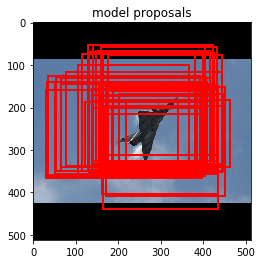

In [407]:
fig3,ax3 = plt.subplots(1)
plt.title('model proposals')
im = get_proper(im_orig)
# im = im_orig.resize((CONST_IMG_SIZE,CONST_IMG_SIZE), Image.ANTIALIAS)
ax3.imshow(im)

# graph the model output
ii = -1
for tmpRect in myProposedRects:
    ii += 1
    rect = patches.Rectangle(
        (tmpRect[0],tmpRect[1]),
        tmpRect[2] - tmpRect[0],
        tmpRect[3] - tmpRect[1],
        linewidth=2,
        edgecolor='r',
        facecolor='none')
    ax3.add_patch(rect)

In [1]:
import caffe
net = caffe.Net('/opt/caffe/neurala/training-pipeline/models/SDK_Nets/allNet5.prototxt', caffe.TRAIN)
